Sort l'information mutuelle entre des neurones pris aléatoirement sur une couche, pour toutes les couches, avec les labels de sortie. (sur les données d'entrainement à 100% accuracy)

Temps d'exécution environ: 70 min

In [1]:
#IPython extension to reload modules before executing user code.
#'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
## NOT USE TO DO NOT USE GPU

import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

#select the best free GPU on the nvidia card
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
bestGPU = 2

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

'''
#set memory usage to 0.5
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))'''

setGPU: Setting GPU to: 2


'\n#set memory usage to 0.5\nfrom keras.backend.tensorflow_backend import set_session\nimport tensorflow as tf\nconfig = tf.ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.5\nset_session(tf.Session(config=config))'

In [3]:
#!pip install -q sklearn
import collections
import numpy as np, numpy
from keract import get_activations, display_activations
import keras
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10, cifar100 # we can use also cifar100
from keras.layers import Input, BatchNormalization, AveragePooling2D, ZeroPadding2D, LeakyReLU, GlobalAveragePooling2D, Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, Model
from keras.regularizers import l2
from keras.utils import plot_model, to_categorical
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy
import sklearn
import sklearn.metrics
import sys
#sys.executable
#sys.path
import time
from IPython.display import SVG

from layca_optimizers import SGD

Using TensorFlow backend.


In [4]:
def normalize(x, mean, std):
    # This function normalizes inputs for zero mean and unit variance to speed up learning.
    
    # In case std = 0, we add eps = 1e-7
    eps = K.epsilon()
    x = (x-mean)/(std+eps)
    return x
  
def import_cifar(dataset):
    if dataset == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    elif dataset == 100:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

    # By default, they are uint8 but we need them float to normalize them
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    # Calculating the mean and standard deviation of the training data
    mean = np.mean(x_train, axis=(0, 1, 2, 3))
    std = np.std(x_train, axis=(0, 1, 2, 3))
    
    # Normalizing 
    x_train = normalize(x_train, mean, std)
    x_test = normalize(x_test, mean, std)

    y_train = to_categorical(y_train, num_classes=dataset)
    y_test = to_categorical(y_test,  num_classes=dataset)
    
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# LOAD DATABase
num_classes = 10
(x_train, y_train), (x_test, y_test) = import_cifar(num_classes)

In [ ]:
# Architecture taken from https://github.com/geifmany/cifar-vgg
# Weight decay and Dropout have been removed
# BatchNormalization before activations
def VGG16_Vanilla_beta(input_shape, num_classes):
    model = Sequential([
        #0
        Conv2D(64, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #3
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #7
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #10
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #14
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #17
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #20
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #24
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #27
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #30
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #34
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #37
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #40
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        #45
        Dense(512),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #48
        Dense(num_classes),
        BatchNormalization(scale=False, center=False),
        Activation('softmax')])
    return model

In [ ]:
def Labilization(labels):
    Labelized = []
    for i in range(len(labels)):
        if labels[i][0] == 1:
            Labelized.append(1)
        elif labels[i][1] == 1:
            Labelized.append(2)
        elif labels[i][2] == 1:
            Labelized.append(3)
        elif labels[i][3] == 1:
            Labelized.append(4)
        elif labels[i][4] == 1:
            Labelized.append(5)
        elif labels[i][5] == 1:
            Labelized.append(6)
        elif labels[i][6] == 1:
            Labelized.append(7)
        elif labels[i][7] == 1:
            Labelized.append(8)
        elif labels[i][8] == 1:
            Labelized.append(9)
        elif labels[i][9] == 1:
            Labelized.append(10)
    return Labelized

In [ ]:
List_of_Pré_Activations = ['conv2d_1/BiasAdd:0','conv2d_2/BiasAdd:0','max_pooling2d_1/MaxPool:0','conv2d_3/BiasAdd:0', 'conv2d_4/BiasAdd:0','max_pooling2d_2/MaxPool:0','conv2d_5/BiasAdd:0', 'conv2d_6/BiasAdd:0','conv2d_7/BiasAdd:0', 'max_pooling2d_3/MaxPool:0','conv2d_8/BiasAdd:0', 'conv2d_9/BiasAdd:0','conv2d_10/BiasAdd:0', 'max_pooling2d_4/MaxPool:0','conv2d_11/BiasAdd:0', 'conv2d_12/BiasAdd:0','conv2d_13/BiasAdd:0', 'max_pooling2d_5/MaxPool:0','dense_1/BiasAdd:0', 'dense_2/BiasAdd:0']
List_of_Post_Activations = [    'activation_1/Relu:0','activation_2/Relu:0',    'activation_3/Relu:0','activation_4/Relu:0',    'activation_5/Relu:0','activation_6/Relu:0',    'activation_7/Relu:0','activation_8/Relu:0',    'activation_9/Relu:0','activation_10/Relu:0',    'activation_11/Relu:0','activation_12/Relu:0',    'activation_13/Relu:0','activation_14/Relu:0',    'activation_15/Softmax:0']

In [ ]:
def MI(IM, nameOfTheLayer, labels):
    
    #nombre de neurones dans la couche
    numNeurons = numpy.size(IM[nameOfTheLayer][0])
    print('number of neurons for the layer: '+str(numNeurons))
    
    # on selectionne des pair de neurones (X,Y) à comparer (regarder l'information mutuelle entre X et Y)
    NeuronsSelected = numpy.zeros((NombreNeurones,1))  # initialize
    for i in range(NombreNeurones):
        NeuronsSelected[i] = numpy.ceil(numpy.random.rand(1)*numNeurons)-1  # on prend 2 neurones selectionnées aleatoirement
    #print(NeuronsSelected[56])
    
    MutualInfo = numpy.zeros((NombreNeurones,1))  # initialization des resultats
    
    #creation de la matrice des activations
    MatrixActivation = np.zeros((numNeurons,nombreDImagesDActivation))
    
    indexActi = -1
    for activation in IM[nameOfTheLayer]:   # on a les activations pour de la couche
        indexActi = indexActi + 1
        activation = activation.flatten() # on a tous nos neurones sur un seul vecteur
        for i in range(numNeurons):
            MatrixActivation[i,indexActi] = activation[i]
                                
    #print(numpy.size(MatrixActivation[0,:])) #100
    #print(numpy.size(MatrixActivation[:,0])) #65534

    #on binarise les activations par rapport à la moyenne de l'activation du neurone
    for j in range(numNeurons):
        neuronMean = numpy.mean(MatrixActivation[j,:])
        for i in range(nombreDImagesDActivation):
            if MatrixActivation[j,i] > neuronMean:
                MatrixActivation[j,i] = 1
            else:
                MatrixActivation[j,i] = 0
                
                
    X= numpy.zeros((1,nombreDImagesDActivation))
    
    #on va calculer la MI d'un neurone avec le label:
    for j in range(NombreNeurones):
        X= MatrixActivation[int(NeuronsSelected[j]),:]
        # example:= sklearn.metrics.normalized_mutual_info_score([1.1,1.0,1.0,1.0,0.0],[1.1,0.1,0.1,1.1,0.1])
        MutualInfo[j] = sklearn.metrics.normalized_mutual_info_score(X,labels,average_method='max')
        #print(MutualInfo[j])
    
    return MutualInfo

In [ ]:
def RUN(IM, modelename, nombreDImagesDActivation, NombreNeurones, labels):
    MIMean = []
    
    print('number of images used for see the activations : '+str(nombreDImagesDActivation) + '\n')
    print('number of neurons analyzed: '+str(NombreNeurones))

    fig = plt.figure(figsize=(10, 60))
    plt.ylim(top=1000)

    print('\n Model :\n')
    i = 1
    for layer in List_of_Post_Activations:
        plt.subplot(20,1,i)
        i = i+1
        #nom de la couche
        print('couche :', str(layer))
        #MI
        MutualInfo = MI(IM, layer, labels)
        MIMean.append(numpy.mean(MutualInfo))
        #plot
        plt.hist(MutualInfo, range = (0, 1.001), bins = 200, color = 'yellow',
            edgecolor = 'red')
        plt.xlabel('Mutual Information with Labels')
        plt.ylabel('Occurence')
        plt.title('\n Occurence of the mutual information with labels post-activation of '+str(nombreDImagesDActivation)+' activation images\n over '+str(NombreNeurones)+' neurons taken randomly\n on the layer '+ str(layer)+' of the model '+str(modelename))
        plt.tight_layout()
        plt.ylim(top=NombreNeurones/10+200)
        plt.axvline(x=MIMean[-1], color='red')
        plt.legend(['MI labels mean'])
        print('MI labels mean: ', str(MIMean[-1]))
    plt.show()

    fig.savefig('figures/MI_labels/MI(A|L)_{}.png'.format(modelename), dpi=100)

    # plot:
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(10, 5))
    plt.ylim(top=0.25)
    nombreCouches = len(MIMean)
    x = range(nombreCouches)

    markerline, stemlines, baseline = plt.stem(x, MIMean, markerfmt='o', label='model ')
    plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
    plt.setp(stemlines, 'linestyle', 'dotted')
    line, = plt.plot(np.mean(MIMean)*np.ones((nombreCouches,1)))

    #extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    #plt.legend([markerline, line], ['MI with labels by layer', 'MI with labels mean'])
    #plt.xlabel('Layers')
    #plt.xticks(np.arange(nombreCouches), ('Conv','Conv','MaxPool','Conv','Conv','MaxPool','Conv','Conv','Conv','MaxPool','Conv','Conv','Conv','MaxPool','Conv','Conv','Conv','MaxPool','Dense','Dense'), rotation=60)
    plt.xticks(np.arange(nombreCouches), ('Conv 1','Conv 2','Conv 3','Conv 4','Conv 5','Conv 6','Conv 7','Conv 8','Conv 9','Conv10','Conv11','Conv12','Conv13','Dense1','Dense2'), rotation=60)
    #plt.ylabel('MI with labels mean')
    plt.grid()
    #plt.title('MI with labels mean post-activation by layer of the model '+modelename+' \n for '+str(nombreDImagesDActivation)+' activation images and '+str(NombreNeurones)+ ' neurons')
    plt.show()
    fig.savefig('figures/MI_labels/MIMean(A|L)_{}.png'.format(modelename), dpi=100)

number of images used for see the activations : 1000

number of neurons analyzed: 10000

 Model :

couche : activation_1/Relu:0
number of neurons for the layer: 65536
MI labels mean:  0.012785618066464246
couche : activation_2/Relu:0
number of neurons for the layer: 65536
MI labels mean:  0.011147831704261344
couche : activation_3/Relu:0
number of neurons for the layer: 32768
MI labels mean:  0.008389651794798466
couche : activation_4/Relu:0
number of neurons for the layer: 32768
MI labels mean:  0.008305078884205832
couche : activation_5/Relu:0
number of neurons for the layer: 16384
MI labels mean:  0.008624723846121026
couche : activation_6/Relu:0
number of neurons for the layer: 16384
MI labels mean:  0.007835046418129937
couche : activation_7/Relu:0
number of neurons for the layer: 16384
MI labels mean:  0.007365904690077605
couche : activation_8/Relu:0
number of neurons for the layer: 8192
MI labels mean:  0.00807910115646458
couche : activation_9/Relu:0
number of neurons for the 

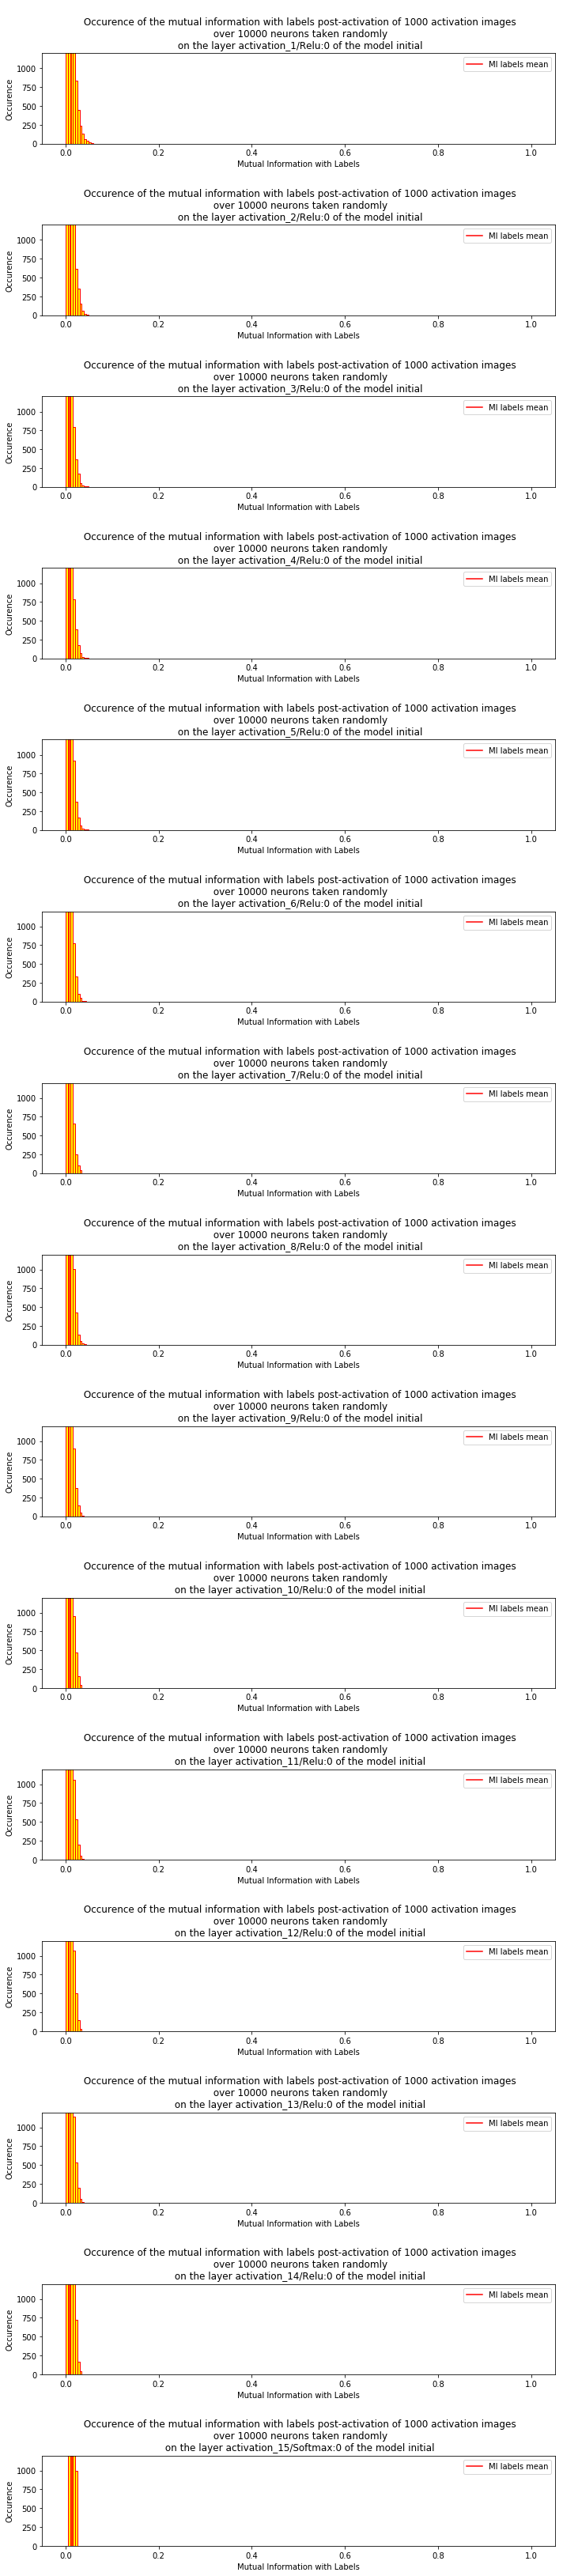

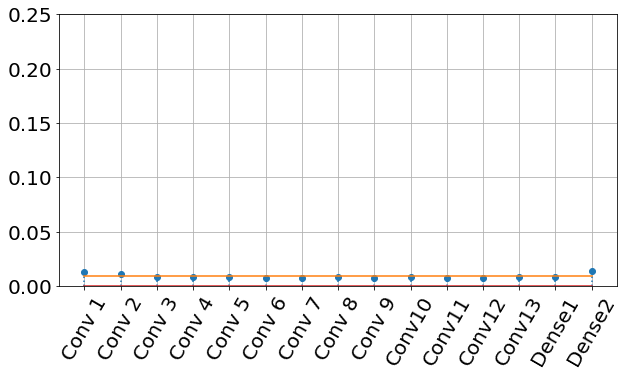

In [ ]:
# LOAD the model and get the activations
modelename = 'vgg16_wdecay_0'
model_name = '../weights/6/{}/initial/weights-initial.hdf5'.format(modelename) #final / initial ! attention au nom de sauvegarde !
modelename = 'initial'
model = VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10)
model.load_weights('{}'.format(model_name))
sgd = optimizers.SGD(lr=0.002, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# On regarde l'activation des neurones pour un echantillon test pris au hasard
Echantillon = []
nombreDImagesDActivation = 1000
NombreNeurones = 10000
choix = np.random.choice(x_train.shape[0], nombreDImagesDActivation)
Echantillon = x_train[choix, :, : , :]
IM = get_activations(model, Echantillon)
labels = y_train[choix]
labels = Labilization(labels)
# Run the code
RUN(IM, modelename, nombreDImagesDActivation, NombreNeurones, labels)

In [ ]:
modelename = 'vgg16_layca_0'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, nombreDImagesDActivation, NombreNeurones, labels)

number of images used for see the activations : 1000

number of neurons analyzed: 10000

 Model :

couche : activation_1/Relu:0
number of neurons for the layer: 65536
MI labels mean:  0.012530394603484997
couche : activation_2/Relu:0
number of neurons for the layer: 65536


In [ ]:
modelename = 'vgg16_layca_1'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, nombreDImagesDActivation, NombreNeurones, labels)

In [ ]:
modelename = 'vgg16_layca_2'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, nombreDImagesDActivation, NombreNeurones, labels)

In [ ]:
modelename = 'vgg16_sgd_0'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, nombreDImagesDActivation, NombreNeurones, labels)

In [ ]:
modelename = 'vgg16_sgd_1'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, nombreDImagesDActivation, NombreNeurones, labels)

In [ ]:
modelename = 'vgg16_sgd_2'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, nombreDImagesDActivation, NombreNeurones, labels)

In [ ]:
modelename = 'vgg16_wdecay_0'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, nombreDImagesDActivation, NombreNeurones, labels)

In [ ]:
modelename = 'vgg16_wdecay_1'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, nombreDImagesDActivation, NombreNeurones, labels)

In [ ]:
modelename = 'vgg16_wdecay_2'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, nombreDImagesDActivation, NombreNeurones, labels)